# **09.분류 실습-캐글 산탄데르 고객 만족 예측**
* XGBoost와 LightGBM을 활용해 예측
* feature 이름은 익명 처리
* 클래스 레이블 명: TARGET => 값이 1이면 불만을 가진 고객, 0이면 만족한 고객
* 성능 평가: ROC-AUC (만족인 데이터가 대부분, 불만족이 일부)

In [ ]:
#데이터 전처리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv('/content/train_santander.csv', encoding = 'latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)


dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,...,num_trasp_var33_out_ult1,num_venta_var44_hace3,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_var2_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,88.89,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,0.18,3.0,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
#전체 데이터의 만족,불만족 비율 분석
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [ ]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,...,num_trasp_var33_out_ult1,num_venta_var44_hace3,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_var2_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.000000,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,0.023652,0.005301,0.001802,0.001447,0.000026,0.000026,0.004196,0.003631,0.002697,0.042370,...,0.000039,0.000158,0.004420,5.393212,3.894396,4.363496,13.651105,0.0,1579.135311,8.913659e+02,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0

In [ ]:
print(cust_df.var3.value_counts()[:10])

var3
 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: count, dtype: int64


=> var3의 min값이 -999999인데 이것이 116개나 존재함
* NaN이나 특정 예외값을 -999999으로 변환한 것으로 보임
* 편차가 심하므로 가장 많은 값인 2로 변환

In [ ]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis = 1, inplace=True)

X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size = 0.2, random_state = 0)
train_cnt = y_train.count()
test_cnt = y_test.count()

print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state=0)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf = XGBClassifier(n_estimators = 500, learning_rate = 0.05, random_state=156, early_stopping_rounds = 100, eval_metric = 'auc')

xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.84104	validation_1-auc:0.81454
[1]	validation_0-auc:0.84488	validation_1-auc:0.81613
[2]	validation_0-auc:0.84812	validation_1-auc:0.81844
[3]	validation_0-auc:0.85180	validation_1-auc:0.81988
[4]	validation_0-auc:0.85424	validation_1-auc:0.82153
[5]	validation_0-auc:0.85771	validation_1-auc:0.82355
[6]	validation_0-auc:0.85919	validation_1-auc:0.82479
[7]	validation_0-auc:0.86097	validation_1-auc:0.82580
[8]	validation_0-auc:0.86158	validation_1-auc:0.82608
[9]	validation_0-auc:0.86252	validation_1-auc:0.82734
[10]	validation_0-auc:0.86337	validation_1-auc:0.82816
[11]	validation_0-auc:0.86438	validation_1-auc:0.82862
[12]	validation_0-auc:0.86544	validation_1-auc:0.82971
[13]	validation_0-auc:0.86660	validation_1-auc:0.83028
[14]	validation_0-auc:0.86727	validation_1-auc:0.83086
[15]	validation_0-auc:0.86787	validation_1-auc:0.83148
[16]	validation_0-auc:0.86869	validation_1-auc:0.83203
[17]	validation_0-auc:0.86900	validation_1-auc:0.83223
[18]	validation_0-au

In [ ]:
#HyperOpt를 이용해 베이지안 최적화 기반으로 XGBoost의 하이퍼 파라미터 튜닝 수행
from hyperopt import hp

#max_depth는 5~15까지 1간격, min_child_weight는 1~6까지 1간격
#colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01~0.2 사이 정규 분포된 값으로 검색
xgb_search_space = {'max_depth':hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight',1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate':hp.uniform('learning_rate', 0.01, 0.2)
                    }

In [ ]:
#목적함수 만들기
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

#fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균 값을 반환
def objective_func(search_space):
  xgb_clf = XGBClassifier(n_estimators = 100, max_depth = int(search_space['max_depth']),
                          min_child_weight = int(search_space['min_child_weight']),
                          colsample_bytree=search_space['colsample_bytree'],
                          learning_rate = search_space['learning_rate'],
                          early_stopping_rounds = 30,
                          eval_metric='auc'
                          )
  #3개 k_fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list=[]

  #3개 k-fold 방식 적용
  roc_auc_list=[]

  #3개의 k-fold 방식 적용
  kf = KFold(n_splits=3)
  #X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

    #1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음
    score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  return -1*np.mean(roc_auc_list)



In [ ]:
from hyperopt import fmin,tpe,Trials

trials = Trials()

#fmin()함수를 호출. max_evals 지정된 함수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo = tpe.suggest,
            max_evals=50,
            trials = trials, rstate = np.random.default_rng(seed=30)
            )

print('best:', best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[41]	validation_0-auc:0.84937	validation_1-auc:0.82997
[42]	validation_0-auc:0.84924	validation_1-auc:0.82986
[43]	validation_0-auc:0.84963	validation_1-auc:0.83033
[44]	validation_0-auc:0.84959	validation_1-auc:0.83017
[45]	validation_0-auc:0.84984	validation_1-auc:0.83045
[46]	validation_0-auc:0.84992	validation_1-auc:0.83043
[47]	validation_0-auc:0.85030	validation_1-auc:0.83078
[48]	validation_0-auc:0.85047	validation_1-auc:0.83139
[49]	validation_0-auc:0.85077	validation_1-auc:0.83187
[50]	validation_0-auc:0.85098	validation_1-auc:0.83209
[51]	validation_0-auc:0.85120	validation_1-auc:0.83239
[52]	validation_0-auc:0.85109	validation_1-auc:0.83216
[53]	validation_0-auc:0.85129	validation_1-auc:0.83237
[54]	validation_0-auc:0.85127	validation_1-auc:0.83235
[55]	validation_0-auc:0.85118	validation_1-auc:0.83225
[56]	validation_0-auc:0.85141	validation_1-auc:0.83242
[57]	validation_0-auc:0.85157	validation_1-auc:0.83253
[58]	validation_0-auc:0.85176

In [ ]:
#n_estimators를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행
xgb_clf = XGBClassifier(n_estimators =500, learning_rate = round(best['learning_rate'], 5),
                        max_depth = int(best['max_depth']),
                        min_child_weight = int(best['min_child_weight']),
                        colsample_bytree = round(best['colsample_bytree'], 5),
                        early_stopping_rounds=100,
                        eval_metric='auc'
                        )

#evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행
xgb_clf.fit(X_tr, y_tr,eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score=roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83498	validation_1-auc:0.80970
[1]	validation_0-auc:0.84565	validation_1-auc:0.81905
[2]	validation_0-auc:0.85153	validation_1-auc:0.82258
[3]	validation_0-auc:0.85373	validation_1-auc:0.82502
[4]	validation_0-auc:0.85643	validation_1-auc:0.82744
[5]	validation_0-auc:0.85797	validation_1-auc:0.83041
[6]	validation_0-auc:0.85994	validation_1-auc:0.83118
[7]	validation_0-auc:0.86125	validation_1-auc:0.83245
[8]	validation_0-auc:0.86264	validation_1-auc:0.83323
[9]	validation_0-auc:0.86388	validation_1-auc:0.83376
[10]	validation_0-auc:0.86518	validation_1-auc:0.83391
[11]	validation_0-auc:0.86607	validation_1-auc:0.83376
[12]	validation_0-auc:0.86688	validation_1-auc:0.83386
[13]	validation_0-auc:0.86759	validation_1-auc:0.83452
[14]	validation_0-auc:0.86879	validation_1-auc:0.83457
[15]	validation_0-auc:0.86940	validation_1-auc:0.83517
[16]	validation_0-auc:0.86983	validation_1-auc:0.83522
[17]	validation_0-auc:0.87016	validation_1-auc:0.83548
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

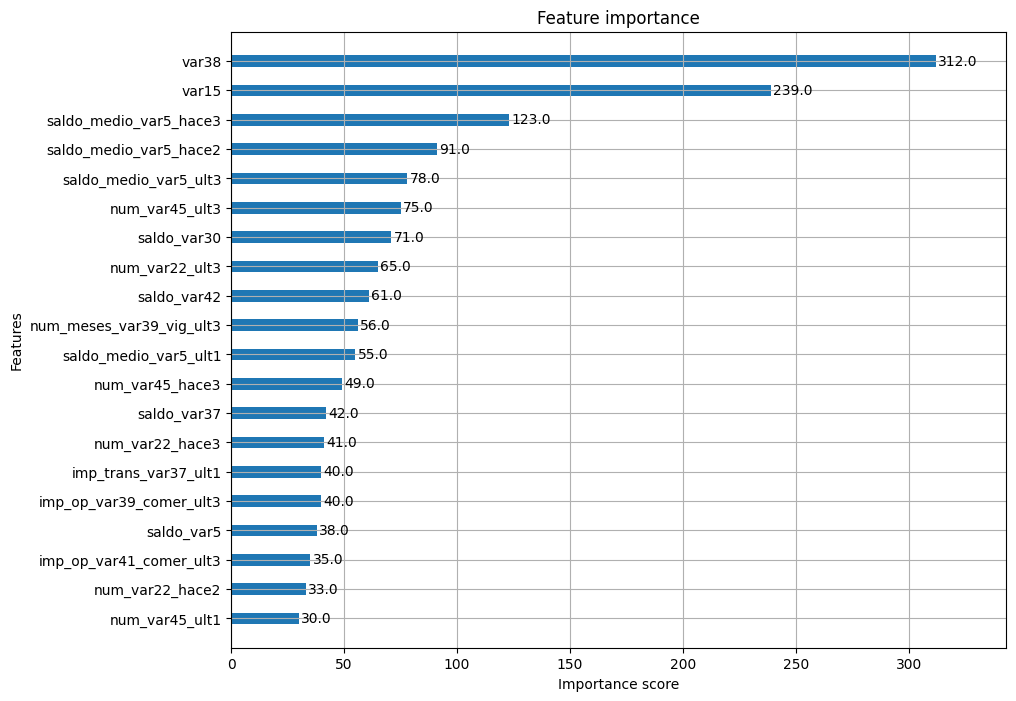

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(1, 1, figsize = (10, 8))
plot_importance(xgb_clf, ax = ax, max_num_features=20, height=0.4)

**LightGBM 모델 학습과 하이퍼 파라미터 튜닝**


In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500, early_stopping_rounds=100, eval_metric='auc')
eval_set = [(X_tr,  y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training un

In [ ]:
lgbm_search_space={'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                   'max_depth':hp.quniform('max_depth', 100, 160, 1),
                   'min_child_samples':hp.quniform('min_child_samples', 60, 100, 1),
                   'subsample':hp.uniform('subsample', 0.7, 1),
                   'learning_rate': hp.uniform('learnings_rate',0.01, 0.2)
                   }

In [ ]:
#목적 함수 생성
def objective_func(search_space):
  lgbm_clf = LGBMClassifier(n_estimators = 100,
                            num_leaves=int(search_space['num_leaves']),
                            max_depth=int(search_space['max_depth']),
                            min_child_samples=int(search_space['min_child_samples']),
                            subsample=search_space['subsample'],
                            learning_rate= search_space['learning_rate'],
                            early_stopping_rounds=30,
                            eval_metric = 'auc'
                            )
  roc_auc_list=[]

  kf=KFold(n_splits=3)
  for tr_index, val_index in kf.split(X_train):
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val,y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    lgbm_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

    score=roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  return -1*np.mean(roc_auc_list)


In [ ]:
from hyperopt import fmin,tpe, Trials

trials =Trials()

best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,max_evals=50,
            trials = trials, rstate=np.random.default_rng(seed=30))

print('best:', best)



[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until va

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                          max_depth = int(best['max_depth']),
                          min_child_samples=int(best['min_child_samples']),
                          subsample=round(best['subsample'],5),
                          learning_rate = round(best['learnings_rate'],5),
                          early_stopping_rounds=100,
                          eval_metric='auc',
                          )

lgbm_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score=roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12898
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 192
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training un

# **Decision Tree And Random Forest Classifier Models**
* dataset : Heart Failure Prediction Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

data = pd.read_csv('/content/drug200.csv')
data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [3]:
data.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [4]:
data.corr(numeric_only= True)

,Age,Na_to_K
Age,1.000000,-0.063119
Na_to_K,-0.063119,1.000000


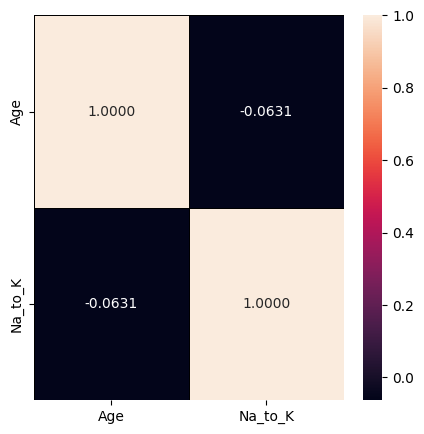

In [5]:
f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(data.corr(numeric_only=True), annot= True, linewidths=0.5, linecolor = 'black', fmt='.4f', ax=ax )
plt.show()

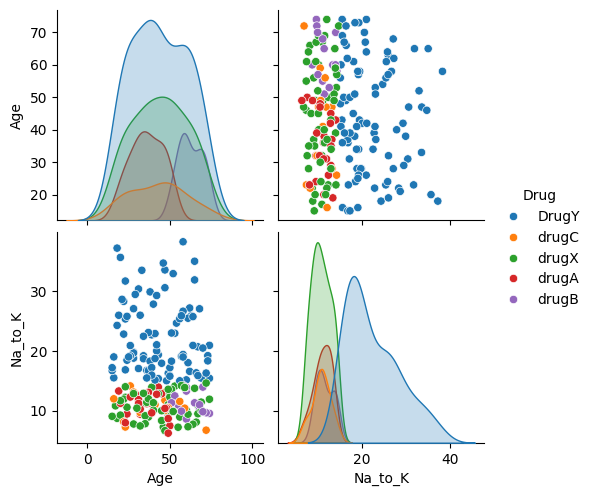

In [6]:
sns.pairplot(data, hue='Drug')

In [7]:
data.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

In [8]:
data['Age'].value_counts(dropna= False)

,count
Age,
47,8
23,7
28,7
49,7
39,6
32,6
50,5
37,5
58,5


In [9]:
data['Sex'].value_counts()

,count
Sex,
M,104
F,96


In [10]:
data["BP"].value_counts()

,count
BP,
HIGH,77
LOW,64
NORMAL,59


In [11]:
data['Cholesterol'].value_counts()

,count
Cholesterol,
HIGH,103
NORMAL,97


In [12]:
data['Drug'].value_counts()

,count
Drug,
DrugY,91
drugX,54
drugA,23
drugC,16
drugB,16


**Data Visualization**

In [13]:
dataAge = data['Age'].value_counts(dropna=False)
npar_dataAge = np.array(dataAge)
x = list(npar_dataAge)
y = data.Age.value_counts().index

DataAge = {'Age': y, 'Number': x}
DataAge = pd.DataFrame(DataAge)

fig = px.bar(DataAge, x = 'Age', y='Number')
fig.show()

In [14]:
colors = ['gold', 'mediumturquoise']

fig= go.Figure(data = [go.Pie(labels = ['M', 'F'], values = [104, 96])])

fig.update_traces(hoverinfo = 'label + percent', textinfo = 'value', textfont_size = 20, marker = dict(colors = colors, line = dict(color = '#000000', width = 2)))
fig.show()

In [15]:
fig = px.bar(x = ['HIGH', 'LOW', 'NORMAL'], y = [77, 64, 59])
fig.show()

In [16]:
fig = px.histogram(x=['HIGH', 'NORMAL'], y = [103, 97])
fig.show()

In [17]:
fig = go.Figure(data = [go.Pie(labels = ['DrugY', 'DrugX', 'DrugA', 'DrugC', 'DrugB'], values = [91, 54, 23, 16, 16])])
fig.update_traces(hoverinfo = 'label + percent', textinfo = 'value', textfont_size = 20,
                  marker = dict(colors = px.colors.sequential.RdBu, line = dict(color = '#000000', width = 2)))
fig.show()

In [18]:
fig = px.scatter(data, x = 'Na_to_K', y='Age', color = 'Drug', size = 'Age', hover_data = ['Na_to_K'])
fig.show()

**Classification Models**

In [19]:
dataclass = pd.read_csv('/content/drug200.csv')
dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [20]:
dataclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [21]:
dataclass.Sex = [1 if i == "F" else 0 for i in dataclass.Sex]

In [22]:
import warnings
warnings.filterwarnings('ignore')

for i in range(0, len(dataclass.BP)):
  if dataclass.BP[i] == "LOW":
    dataclass.BP[i] = 2

  elif dataclass.BP[i] == "NORMAL":
    dataclass.BP[i] = 1

  else:
    dataclass.BP[i] = 0

dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,0,HIGH,25.355,DrugY
1,47,0,2,HIGH,13.093,drugC
2,47,0,2,HIGH,10.114,drugC
3,28,1,1,HIGH,7.798,drugX
4,61,1,2,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,1,2,HIGH,11.567,drugC
196,16,0,2,HIGH,12.006,drugC
197,52,0,1,HIGH,9.894,drugX
198,23,0,1,NORMAL,14.020,drugX


In [23]:
dataclass.Cholesterol = [1 if i == 'HIGH' else 0 for i in dataclass.Cholesterol]
dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,0,1,25.355,DrugY
1,47,0,2,1,13.093,drugC
2,47,0,2,1,10.114,drugC
3,28,1,1,1,7.798,drugX
4,61,1,2,1,18.043,DrugY
...,...,...,...,...,...,...
195,56,1,2,1,11.567,drugC
196,16,0,2,1,12.006,drugC
197,52,0,1,1,9.894,drugX
198,23,0,1,0,14.020,drugX


In [24]:
import warnings
warnings.filterwarnings('ignore')

for i in range(0, len(dataclass)):
  if dataclass.Drug[i] == "DrugY":
    dataclass.Drug[i] = 4
  elif dataclass.Drug[i] == 'drugX':
    dataclass.Drug[i] = 3
  elif dataclass.Drug[i] == 'drugA':
    dataclass.Drug[i] = 2
  elif dataclass.Drug[i] == 'drugC':
    dataclass.Drug[i] = 1
  else:
    dataclass.Drug[i] = 0

dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,0,1,25.355,4
1,47,0,2,1,13.093,1
2,47,0,2,1,10.114,1
3,28,1,1,1,7.798,3
4,61,1,2,1,18.043,4
...,...,...,...,...,...,...
195,56,1,2,1,11.567,1
196,16,0,2,1,12.006,1
197,52,0,1,1,9.894,3
198,23,0,1,0,14.020,3


In [25]:
dataclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    int64  
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    int64  
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 9.5+ KB


In [26]:
data_types_dict = {'BP': int, "Drug": int}

dataclass = dataclass.astype(data_types_dict)
dataclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    int64  
 2   BP           200 non-null    int64  
 3   Cholesterol  200 non-null    int64  
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 9.5 KB


In [27]:
x_data = dataclass.drop(['Drug'], axis = 1)

y_data = dataclass.Drug.values
x_data

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,1,0,1,25.355
1,47,0,2,1,13.093
2,47,0,2,1,10.114
3,28,1,1,1,7.798
4,61,1,2,1,18.043
...,...,...,...,...,...
195,56,1,2,1,11.567
196,16,0,2,1,12.006
197,52,0,1,1,9.894
198,23,0,1,0,14.020


In [28]:
y_data

array([4, 1, 1, 3, 4, 3, 4, 1, 4, 4, 1, 4, 4, 4, 3, 4, 3, 2, 1, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 4, 4, 3, 0, 3, 4, 3, 3, 2, 3, 3, 3, 4, 0, 4, 3,
       3, 3, 2, 1, 4, 4, 4, 3, 4, 4, 0, 1, 0, 4, 3, 4, 4, 2, 4, 3, 0, 4,
       2, 3, 4, 4, 0, 4, 3, 4, 4, 4, 2, 4, 2, 3, 0, 3, 1, 2, 1, 0, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 2, 1, 3, 4, 3, 3, 4, 0, 4,
       2, 3, 3, 3, 3, 4, 3, 3, 2, 4, 4, 4, 4, 4, 0, 4, 4, 3, 4, 3, 4, 4,
       3, 4, 4, 3, 0, 2, 0, 3, 2, 4, 0, 4, 2, 3, 3, 2, 3, 1, 2, 0, 3, 3,
       4, 1, 2, 4, 1, 3, 3, 0, 3, 4, 4, 4, 4, 3, 4, 2, 3, 3, 4, 4, 2, 4,
       2, 4, 4, 4, 4, 3, 3, 4, 4, 4, 0, 2, 4, 4, 4, 2, 4, 1, 4, 1, 1, 3,
       3, 3])

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3, random_state=1)

**decision tree classifier**

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

dtc = DecisionTreeClassifier()

dtc.fit(x_train, y_train)
predict = dtc.predict(x_test)

print('The accuracy of the Deicision Tree is', metrics.accuracy_score(predict, y_test))

The accuracy of the Deicision Tree is 0.9666666666666667


In [31]:
DTC_gini = DecisionTreeClassifier(criterion = 'gini', max_depth=3, random_state=0)

DTC_gini.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [32]:
y_pred_gini = DTC_gini.predict(x_test)

In [33]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:.4f}'.format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.9000


In [34]:
y_pred_train_gini = DTC_gini.predict(x_train)

y_pred_train_gini

array([3, 3, 2, 4, 2, 3, 3, 3, 4, 2, 0, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4,
       3, 4, 2, 4, 3, 3, 2, 3, 4, 2, 0, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3,
       3, 0, 0, 2, 4, 3, 4, 3, 4, 4, 3, 3, 4, 4, 2, 4, 4, 4, 2, 3, 4, 4,
       4, 3, 4, 3, 3, 2, 3, 2, 4, 4, 4, 4, 3, 4, 0, 3, 3, 4, 0, 4, 0, 4,
       4, 0, 4, 4, 2, 3, 4, 3, 2, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4,
       4, 2, 3, 3, 3, 4, 3, 4, 4, 4, 0, 4, 2, 3, 3, 2, 4, 4, 4, 4, 4, 3,
       2, 4, 3, 4, 2, 3, 2, 3])

In [35]:
print('Training-set accuracy score:{0:.4f}'.format(accuracy_score(y_train, y_pred_train_gini)))

Training-set accuracy score:0.9143


In [36]:
print('Training set score: {:.4f}'.format(DTC_gini.score(x_train, y_train)))
print('Test set score:{:.4f}',format(DTC_gini.score(x_test, y_test)))

Training set score: 0.9143
Test set score:{:.4f} 0.9


**Deicision Tree classifier with entropy**


In [37]:
DTC_en = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 0)

DTC_en.fit(x_train, y_train)

y_pred_en = DTC_en.predict(x_test)
print('Model accuracy score with criterion entropy:{0:.4f}'.format(accuracy_score(y_test, y_pred_en)))

Model accuracy score with criterion entropy:0.9000


In [38]:
y_pred_train_en = DTC_en.predict(x_train)
y_pred_train_en

array([3, 3, 2, 4, 2, 3, 3, 3, 4, 2, 0, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4,
       3, 4, 2, 4, 3, 3, 2, 3, 4, 2, 0, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3,
       3, 0, 0, 2, 4, 3, 4, 3, 4, 4, 3, 3, 4, 4, 2, 4, 4, 4, 2, 3, 4, 4,
       4, 3, 4, 3, 3, 2, 3, 2, 4, 4, 4, 4, 3, 4, 0, 3, 3, 4, 0, 4, 0, 4,
       4, 0, 4, 4, 2, 3, 4, 3, 2, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4,
       4, 2, 3, 3, 3, 4, 3, 4, 4, 4, 0, 4, 2, 3, 3, 2, 4, 4, 4, 4, 4, 3,
       2, 4, 3, 4, 2, 3, 2, 3])

In [39]:
print('Training-set accuracy score:{0:0.4f}'.format(accuracy_score(y_train, y_pred_train_en)))

Training-set accuracy score:0.9143


In [40]:
print('Training set score:{:.4f}'.format(DTC_en.score(x_train, y_train)))

print('Test set score:{:.4f}'.format(DTC_en.score(x_test, y_test)))

Training set score:0.9143
Test set score:0.9000


**Random Forest Classifier**


In [41]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 0)

rfc.fit(x_train, y_train)
predict = rfc.predict(x_test)

print('The accuracy of the Random Forest is', metrics.accuracy_score(predict, y_test))

The accuracy of the Random Forest is 0.95


In [42]:
from sklearn.ensemble import RandomForestClassifier

rfc_100 = RandomForestClassifier(n_estimators = 100, random_state = 0)

rfc_100.fit(x_train, y_train)
predict = rfc_100.predict(x_test)

print('The accuracy of the Random Forest is', metrics.accuracy_score(predict, y_test))

The accuracy of the Random Forest is 0.95


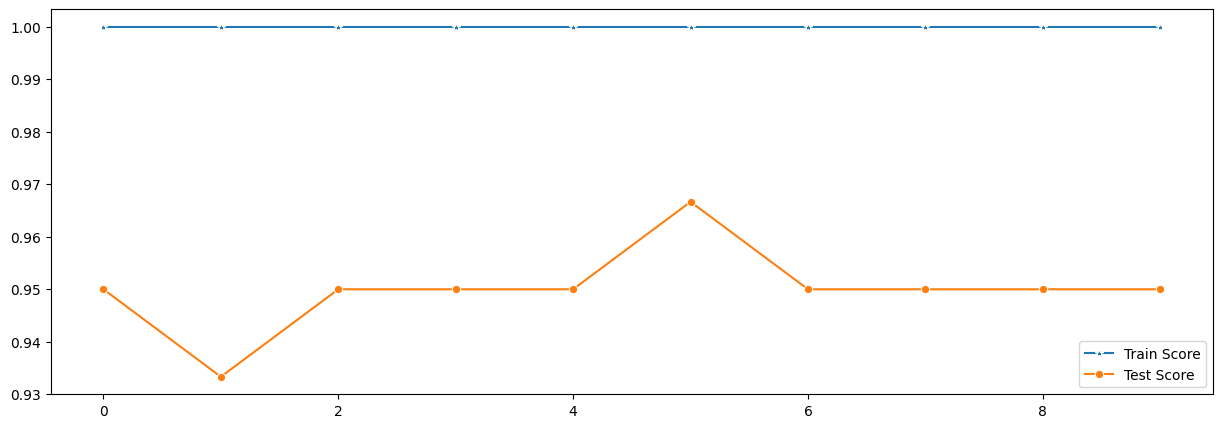

In [43]:
test_score_list = []
train_score_list = []

for i in range(0,10):
  rfc2 = RandomForestClassifier(random_state =i)
  rfc2.fit(x_train, y_train)
  test_score_list.append(rfc2.score(x_test, y_test))
  train_score_list.append(rfc2.score(x_train, y_train))

plt.figure(figsize= (15,5))
p = sns.lineplot(x=range(0,10), y=train_score_list, marker ='*', label = 'Train Score')
p = sns.lineplot(x=range(0,10), y=test_score_list, marker = 'o', label = 'Test Score')

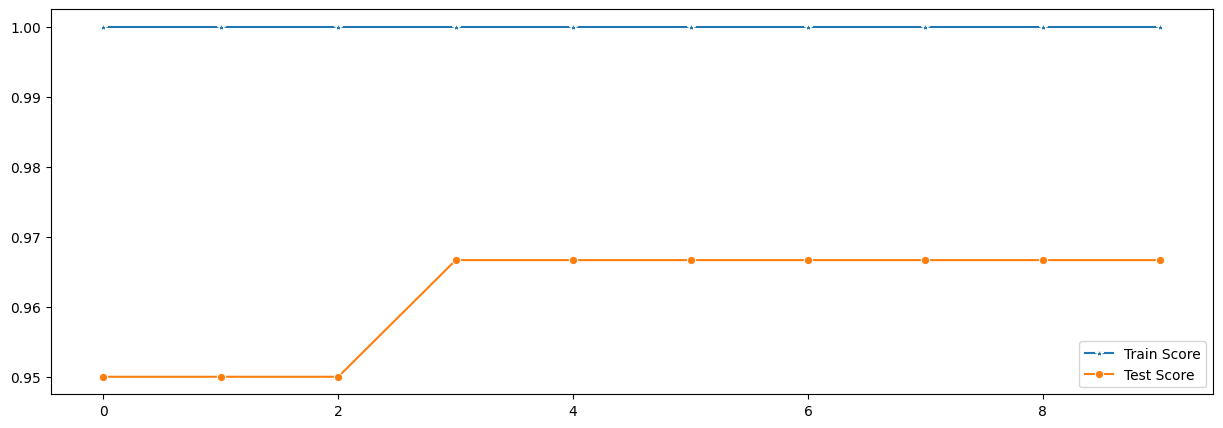

In [44]:
test_score_list = []
train_score_list = []

list_n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for i in range(0, len(list_n_estimators)):
  rfc3 = RandomForestClassifier(n_estimators=list_n_estimators[i], random_state=5)
  rfc3.fit(x_train, y_train)
  test_score_list.append(rfc3.score(x_test, y_test))
  train_score_list.append(rfc3.score(x_train, y_train))

plt.figure(figsize = (15,5))
p = sns.lineplot(x=range(0, len(list_n_estimators)), y=train_score_list, marker='*', label='Train Score')
p = sns.lineplot(x=range(0, len(list_n_estimators)), y=test_score_list, marker = 'o', label = 'Test Score')

**Random Forest Classifier With The Best Parameters**


In [45]:
last_rfc = RandomForestClassifier(n_estimators = 100, random_state=5)


last_rfc.fit(x_train, y_train)

predict = last_rfc.predict(x_test)

print('The accuracy of the Random Forest is', metrics.accuracy_score(predict, y_test))

The accuracy of the Random Forest is 0.9666666666666667


In [46]:
y_pred_en = last_rfc.predict(x_test)

In [47]:
print('Model accuracy score with best parameters:{0:.4f}'.format(accuracy_score(y_test, y_pred_en)))


Model accuracy score with best parameters:0.9667


In [48]:
y_pred_train_en = last_rfc.predict(x_train)
y_pred_train_en

array([3, 3, 2, 4, 2, 3, 3, 3, 4, 2, 0, 1, 4, 1, 4, 3, 4, 3, 4, 4, 4, 4,
       3, 4, 2, 4, 1, 3, 2, 3, 4, 2, 0, 0, 3, 3, 1, 3, 3, 4, 4, 4, 4, 3,
       1, 0, 0, 2, 4, 3, 4, 1, 4, 4, 1, 3, 4, 4, 2, 4, 4, 4, 2, 3, 4, 4,
       4, 3, 4, 1, 3, 2, 3, 2, 4, 4, 4, 4, 3, 4, 0, 3, 3, 4, 0, 4, 0, 4,
       4, 0, 4, 4, 2, 3, 4, 3, 2, 4, 1, 4, 4, 3, 4, 4, 4, 4, 4, 4, 1, 4,
       4, 2, 3, 1, 1, 4, 3, 4, 4, 4, 0, 4, 2, 3, 3, 2, 4, 4, 4, 4, 4, 3,
       2, 4, 3, 4, 2, 3, 2, 3])

In [49]:
print('Training-set accuracy score: {0:.4f}'.format(accuracy_score(y_train, y_pred_train_en)))

Training-set accuracy score: 1.0000


In [50]:
print('Training set score: {:.4f}'.format(last_rfc.score(x_train, y_train)))
print('Test set score:{:.4f}'.format(last_rfc.score(x_test, y_test)))

Training set score: 1.0000
Test set score:0.9667


**Evaluation Classification Models**

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

cm_des = DecisionTreeClassifier()

cm_des.fit(x_train, y_train)

y_pred_cm = cm_des.predict(x_test)
y_true = y_test

cm_des1 = confusion_matrix(y_true, y_pred_cm)
cm_des1

array([[ 4,  0,  2,  0,  0],
       [ 0,  4,  0,  0,  0],
       [ 0,  0,  4,  0,  0],
       [ 0,  0,  0, 19,  0],
       [ 0,  0,  0,  0, 27]])

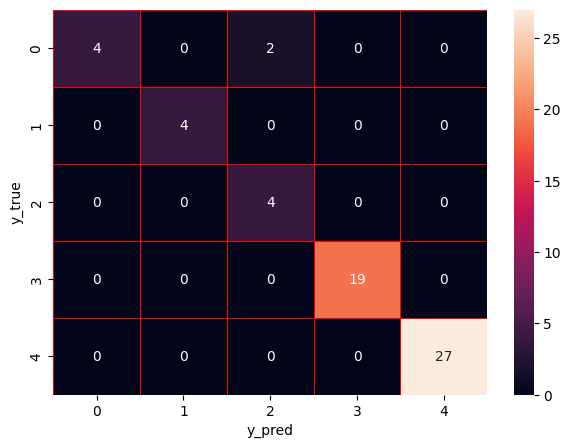

In [52]:
f, ax = plt.subplots(figsize=(7,5))
sns.heatmap(cm_des1, annot=True, linewidths=0.5, linecolor = 'red', fmt = '.0f', ax = ax)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

In [53]:
cm_des_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

cm_des_gini.fit(x_train, y_train)

y_pred_cm = cm_des_gini.predict(x_test)
y_true = y_test

cm_des2 = confusion_matrix(y_true, y_pred_cm)
cm_des2

array([[ 4,  0,  2,  0,  0],
       [ 0,  0,  0,  4,  0],
       [ 0,  0,  4,  0,  0],
       [ 0,  0,  0, 19,  0],
       [ 0,  0,  0,  0, 27]])

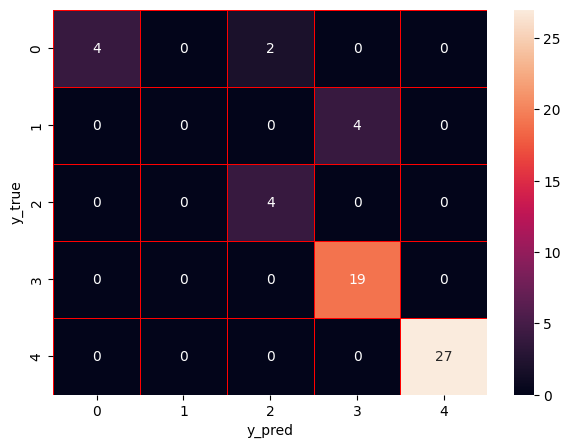

In [54]:
f,ax = plt.subplots(figsize=(7,5))
sns.heatmap(cm_des2, annot= True, linewidths = 0.5, linecolor = 'red', fmt='.0f', ax = ax)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

In [55]:
cm_last_rfc = RandomForestClassifier(n_estimators = 100, random_state=5)

cm_last_rfc.fit(x_train, y_train)

y_pred_cm = cm_last_rfc.predict(x_test)
y_true = y_test

cm_rfc = confusion_matrix(y_true, y_pred_cm)
cm_rfc

array([[ 4,  0,  2,  0,  0],
       [ 0,  4,  0,  0,  0],
       [ 0,  0,  4,  0,  0],
       [ 0,  0,  0, 19,  0],
       [ 0,  0,  0,  0, 27]])

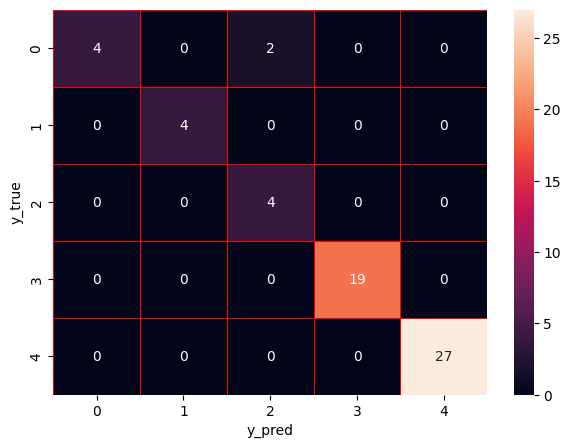

In [56]:
f, ax = plt.subplots(figsize=(7,5))
sns.heatmap(cm_rfc, annot=True, linewidths = 0.5, linecolor = 'red', fmt='.0f', ax = ax)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

# **Beginner Friendly CATBOOST with OPTUNA**

In [57]:
!pip install optuna

In [58]:
!pip install catboost

In [71]:
!pip install plotly chart_studio

In [59]:
!pip install plotly==4.14.3 cufflinks==0.17.3

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import KFold, cross_val_predict, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [61]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 900)

pd.set_option('display.max_colwidth', 200)
df=pd.read_csv('/content/heart.csv')
df.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [63]:
df.duplicated().sum() #중복된 행 확인

0

In [64]:
def missing(df):
  missing_number = df.isnull().sum().sort_values(ascending=False)
  missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
  return missing_values

missing(df)

,Missing_Number,Missing_Percent
Age,0,0.0
Sex,0,0.0
ChestPainType,0,0.0
RestingBP,0,0.0
Cholesterol,0,0.0
FastingBS,0,0.0
RestingECG,0,0.0
MaxHR,0,0.0
ExerciseAngina,0,0.0
Oldpeak,0,0.0


In [65]:
numerical = df.drop(['HeartDisease'], axis =1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns: {df[numerical].columns}')
print('\n')
print(f'Catergorical Columns: {df[categorical].columns}')

Numerical Columns: Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


Catergorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [66]:
df[categorical].nunique() #고윳값의 수 출력

,0
Sex,2
ChestPainType,4
RestingECG,3
ExerciseAngina,2
ST_Slope,3


In [67]:
y = df['HeartDisease']
print(f'Percentage of patient had a HeartDisease: {round(y.value_counts(normalize=True)[1]*100, 2)} %  --> ({y.value_counts()[1]}patient)\nPercentage of patient did not have a HeartDisease: {round(y.value_counts(normalize=True)[0]*100,2)} % --> ({y.value_counts()[0]} patient)' )

Percentage of patient had a HeartDisease: 55.34 %  --> (508patient)
Percentage of patient did not have a HeartDisease: 44.66 % --> (410 patient)


In [105]:
df['HeartDisease'].iplot(kind='hist')

In [69]:
df[numerical].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000


In [104]:
df[numerical].iplot(kind='hist');

In [103]:
df[numerical].iplot(kind='histogram',subplots=True,bins=50)

In [78]:
skew_limit = 0.75
skew_vals = df[numerical].drop('FastingBS', axis = 1).skew()
skew_cols = skew_vals[abs(skew_vals)>skew_limit].sort_values(ascending=False)
skew_cols

,0
Oldpeak,1.022872


<Axes: >

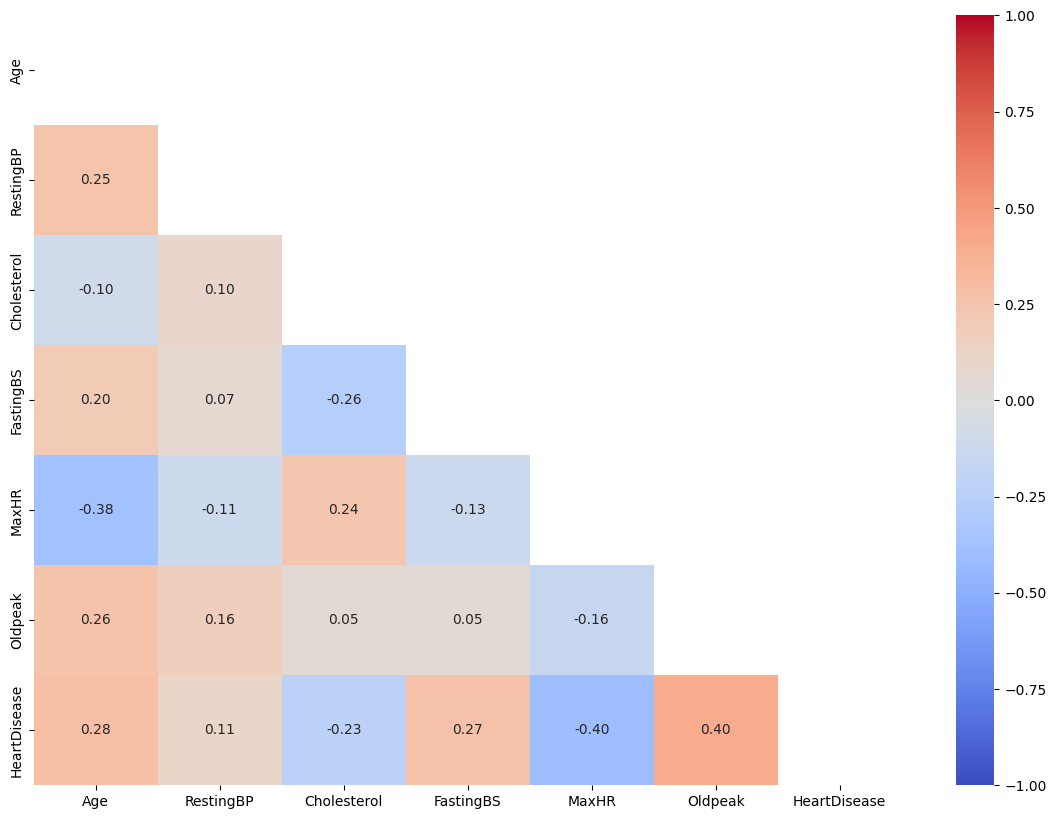

In [79]:
numerical1 = df.select_dtypes('number').columns

matrix = np.triu(df[numerical1].corr())
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df[numerical1].corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=matrix, ax = ax)

In [80]:
df[categorical].head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up


In [81]:
print(f'A female person has a probability of {round(df[df["Sex"]=="F"]["HeartDisease"].mean()*100,2)} % have a HeartDisease')

print()

print(f'A male person has a probability of {round(df[df["Sex"]=="M"]["HeartDisease"].mean()*100, 2)} % have a HeartDisease')

print()

A female person has a probability of 25.91 % have a HeartDisease

A male person has a probability of 63.17 % have a HeartDisease



In [82]:
fig = px.histogram(df, x="Sex", color= df['HeartDisease'].astype(str), width=400, height =400)
fig.show()

In [83]:
df.groupby('ChestPainType')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ChestPainType,
ASY,0.790323
TA,0.434783
NAP,0.354680
ATA,0.138728


In [84]:
fig = px.histogram(df, x="ChestPainType", color = "HeartDisease", width=400, height=400)
fig

In [85]:
df.groupby('RestingECG')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
RestingECG,
ST,0.657303
LVH,0.563830
Normal,0.516304


In [86]:
fig = px.histogram(df, x = "RestingECG", color = "HeartDisease", width=400, height = 400)
fig

In [87]:
df.groupby('ExerciseAngina')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ExerciseAngina,
Y,0.851752
N,0.351005


In [88]:
fig = px.histogram(df, x="ExerciseAngina",  color = "HeartDisease", width=400, height=400)
fig

In [89]:
df.groupby('ST_Slope')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ST_Slope,
Flat,0.828261
Down,0.777778
Up,0.197468


In [90]:
fig = px.histogram(df, x = "ST_Slope", color = "HeartDisease", width = 400, height = 400)
fig

**Model Selection**
1. base model: dummy classifier model
2. Logistic& Linear Discriminant & KNN & SVM model
3. Adaboost, RandomForest, Gradient Boosting, Extra trees
4. XGBoost, LightGBM, Catboost
5. hyperparameter tuning for Catboost

In [91]:
#Baseline Model
accuracy = []
model_names = []

X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

ohe = OneHotEncoder()
ct = make_column_transformer((ohe, categorical), remainder = 'passthrough')

model = DummyClassifier(strategy ='constant', constant = 1)
pipe = make_pipeline(ct, model)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred), 4))
print(f'model: {model} and accuracy score is : {round(accuracy_score(y_test, y_pred), 4)}')

model_names = ['DummyClassifier']
dummy_result_df = pd.DataFrame({'Accuracy':accuracy}, index = model_names)
dummy_result_df

model: DummyClassifier(constant=1, strategy='constant') and accuracy score is : 0.5942


,Accuracy
DummyClassifier,0.5942


In [92]:
#Logistic&Linear Discriminant & SVC & KNN
accuracy = []
model_names =[]

X=df.drop('HeartDisease', axis = 1)
y =df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

ohe = OneHotEncoder()
ct = make_column_transformer((ohe, categorical), remainder = 'passthrough')

lr = LogisticRegression(solver = 'liblinear')
lda = LinearDiscriminantAnalysis()
svm = SVC(gamma = 'scale')
knn = KNeighborsClassifier()

models = [lr, lda, svm, knn]

for model in models:
  pipe = make_pipeline(ct, model)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  accuracy.append(round(accuracy_score(y_test, y_pred), 4))
  print(f'model: {model} and accuracy score is : {round(accuracy_score(y_test, y_pred), 4)}')

model_names = ['Logistic', 'LinearDiscriminant', 'SVM', 'KNeighbors']
result_df1 = pd.DataFrame({'Accuracy':accuracy}, index = model_names)
result_df1

model: LogisticRegression(solver='liblinear') and accuracy score is : 0.8841
model: LinearDiscriminantAnalysis() and accuracy score is : 0.8696
model: SVC() and accuracy score is : 0.7246
model: KNeighborsClassifier() and accuracy score is : 0.7174


,Accuracy
Logistic,0.8841
LinearDiscriminant,0.8696
SVM,0.7246
KNeighbors,0.7174


In [93]:
#Logistice&Linear Discriminant&SVC&KNN with Scaler
accuracy = []
model_names =[]

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

ohe = OneHotEncoder()
s = StandardScaler()
ct1 = make_column_transformer((ohe, categorical), (s,numerical))

lr = LogisticRegression(solver = 'liblinear')
lda = LinearDiscriminantAnalysis()
svm = SVC(gamma = 'scale')
knn = KNeighborsClassifier()

models = [lr, lda, svm, knn]

for model in models:
  pipe = make_pipeline(ct1, model)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  accuracy.append(round(accuracy_score(y_test, y_pred), 4))
  print(f'model: {model} and accuracy score is : {round(accuracy_score(y_test, y_pred), 4)}')

model_names = ['Logistic_scl', 'LinearDiscriminant_scl', 'SVM_scl', 'KNeighbors_scl']
result_df2 = pd.DataFrame({'Accuracy':accuracy}, index = model_names)
result_df2

model: LogisticRegression(solver='liblinear') and accuracy score is : 0.8804
model: LinearDiscriminantAnalysis() and accuracy score is : 0.8696
model: SVC() and accuracy score is : 0.8841
model: KNeighborsClassifier() and accuracy score is : 0.8841


,Accuracy
Logistic_scl,0.8804
LinearDiscriminant_scl,0.8696
SVM_scl,0.8841
KNeighbors_scl,0.8841


In [94]:
#Ensemble Models(AdaBoost & Gradient Boosting & Random Forest & Extra Trees)
accuracy = []
model_names =[]

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

ohe = OneHotEncoder()
ct = make_column_transformer((ohe, categorical), remainder = 'passthrough')

ada = AdaBoostClassifier(random_state = 0)
gb = GradientBoostingClassifier(random_state = 0)
rf = RandomForestClassifier(random_state = 0)
et = ExtraTreesClassifier(random_state=0)

models = [ada, gb, rf, et]

for model in models:
  pipe = make_pipeline(ct, model)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  accuracy.append(round(accuracy_score(y_test, y_pred), 4))
  print(f'model: {model} and accuracy score is : {round(accuracy_score(y_test, y_pred), 4)}')


model_names = ['Ada', 'Gradient','Random', 'ExtraTree']
result_df3 = pd.DataFrame({'Accuracy':accuracy}, index = model_names)
result_df3

model: AdaBoostClassifier(random_state=0) and accuracy score is : 0.8732
model: GradientBoostingClassifier(random_state=0) and accuracy score is : 0.8768
model: RandomForestClassifier(random_state=0) and accuracy score is : 0.8877
model: ExtraTreesClassifier(random_state=0) and accuracy score is : 0.8804


,Accuracy
Ada,0.8732
Gradient,0.8768
Random,0.8877
ExtraTree,0.8804


In [95]:
#Famous Trio(XGBoost & LightGBM & Catboost)
accuracy = []
model_names = []

X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

ohe = OneHotEncoder()
ct = make_column_transformer((ohe, categorical), remainder = 'passthrough')

xgbc = XGBClassifier(random_state = 0)
lgbmc = LGBMClassifier(random_state=0)

models = [xgbc, lgbmc]

for model in models:
  pipe = make_pipeline(ct, model)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['XGBosst', 'LightGBM']
result_df4 = pd.DataFrame({'Accuracy': accuracy}, index = model_names)
result_df4

[LightGBM] [Info] Number of positive: 344, number of negative: 298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 642, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535826 -> initscore=0.143548
[LightGBM] [Info] Start training from score 0.143548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

,Accuracy
XGBosst,0.8478
LightGBM,0.8732


In [96]:
#CATBOOST
#Logloss - The target has only two diff values or the target_border parameter is not None
#MultiClass-The target has more than two different values and the border_count parameter is None
accuracy = []
model_names = []

X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']
categorical_features_indices = np.where(X.dtypes !=np.float64)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = CatBoostClassifier(verbose = False, random_state=0)

model.fit(X_train, y_train, cat_features = categorical_features_indices, eval_set = (X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred), 4))

model_names = ['Catboost_default']
result_df5 = pd.DataFrame({'Accuracy': accuracy}, index = model_names)
result_df5

,Accuracy
Catboost_default,0.8804


In [97]:
#Catboost HyperParameter Tuning with Optuna
def objective(trial):
  X=df.drop('HeartDisease', axis = 1)
  y= df['HeartDisease']
  categorical_features_indices = np.where(X.dtypes != np.float64)[0]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

  param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "3gb",
    }

  if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
  elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

  cat_cls = CatBoostClassifier(**param, early_stopping_rounds=100)

  cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features = categorical_features_indices, verbose =0)

  preds = cat_cls.predict(X_test)
  pred_labels = np.rint(preds)
  accuracy = accuracy_score(y_test, pred_labels)
  return accuracy

if __name__ == "__main__":
  study = optuna.create_study(direction = "maximize")
  study.optimize(objective, n_trials = 50, timeout=600)

  print("Number of finished trials : {}".format(len(study.trials)))

  print("Best trial:")
  trial = study.best_trial

  print("  Value : {}".format(trial.value))

  print("  Params:")
  for key, value in trial.params.items():
    print("     {}: {}".format(key, value))


[I 2025-10-05 17:49:20,655] A new study created in memory with name: no-name-25480041-203d-426d-a8c9-16c0a9d31d24
[I 2025-10-05 17:49:22,412] Trial 0 finished with value: 0.8840579710144928 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.04010988554505367, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.8840579710144928.
[I 2025-10-05 17:49:27,513] Trial 1 finished with value: 0.8804347826086957 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07749443741967171, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.134915639678977}. Best is trial 0 with value: 0.8840579710144928.
[I 2025-10-05 17:49:36,357] Trial 2 finished with value: 0.894927536231884 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.0654025674306577, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.684476633977708}. Best is t

Number of finished trials : 50
Best trial:
  Value : 0.8985507246376812
  Params:
     objective: CrossEntropy
     colsample_bylevel: 0.028958741234640782
     depth: 11
     boosting_type: Ordered
     bootstrap_type: MVS


**parameters**
* objective: Supported metrics for overfitting detection and best model selection
* colsample_byleve: this parameter speeds up the training and usually does not affect the quality
* depth:depth of the tree
* boosting_type: By default, the boosting type is set to for small datasets. This prevents overfitting but it's expensive in terms of computation.
* bootstrap_type: By default, the method for sampling the weights of objects is set to.

In [99]:
#use out best model with new parameters
accuracy = []
model_names = []

X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']
categorical_features_indices = np.where(X.dtypes !=np.float64)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

model = CatBoostClassifier(verbose = False, random_state=0, objective = 'CrossEntropy',
                           colsample_bylevel = 0.04292240490294766,
                           depth = 10,
                           boosting_type = 'Plain',
                           bootstrap_type = 'MVS')

model.fit(X_train, y_train, cat_features = categorical_features_indices, eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred), 4))
print(classification_report(y_test, y_pred))

model_names = ['Catboost_tuned']
result_df6 = pd.DataFrame({'Accuracy': accuracy}, index = model_names)
result_df6

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       112
           1       0.93      0.91      0.92       164

    accuracy                           0.91       276
   macro avg       0.90      0.91      0.91       276
weighted avg       0.91      0.91      0.91       276



,Accuracy
Catboost_tuned,0.9094


In [100]:
#Feature Importance
feature_importance = np.array(model.get_feature_importance())
features = np.array(X_train.columns)
fi={'features':features,'feature_importance':feature_importance}
df_fi = pd.DataFrame(fi)
df_fi.sort_values(by=['feature_importance'], ascending=True,inplace=True)
fig = px.bar(df_fi, x='feature_importance', y='features',title="CatBoost Feature Importance",height=500)
fig.show()

In [101]:
#Moel Comparison
result_final = pd.concat([dummy_result_df,result_df1,result_df2,result_df3,result_df4,result_df5,result_df6],axis=0)


In [102]:
result_final.sort_values(by=['Accuracy'], ascending=True,inplace=True)
fig = px.bar(result_final, x='Accuracy', y=result_final.index,title='Model Comparison',height=600,labels={'index':'MODELS'})
fig.show()